# PyVRP: Hybrid Genetic Search for the VRPTW
This notebook contains an example of how to use the PyVRP library to solve the Vehicle Routing Problem with Time Windows (VRPTW).

In [1]:
import os
import sys
import numpy as np
from typing import Optional
from functools import partial

import pyvrp
from pyvrp import GeneticAlgorithm, Population, read
from pyvrp._lib.hgspy import (
    LocalSearch,
    PenaltyManager,
    ProblemData,
    XorShift128,
    crossover,
    diversity,
    operators,
)
from pyvrp.stop import MaxIterations, MaxRuntime, StoppingCriterion

# TODO add as dependency
sys.path.append(os.path.join("..", "..", "..", "CVRPLIB"))
import cvrplib

import matplotlib.pyplot as plt
from pyvrp.plotting import plot_vrptw, plot_timew, plot_demands, plot_schedule

## Read and visualize problem data

In [2]:
DATA_ROOT = os.path.abspath(os.path.join("..", "..", "data"))
SOLOMON_DIR = os.path.join(DATA_ROOT, "vrptw", "Solomon")
ORTEC_DIR = os.path.join(DATA_ROOT, "vrptw", "ORTEC")

# For DIMACS objective, we may want to truncate to 1 decimal (scale and truncate to int)
def truncate_to_decimals(distance, decimals=0):
    return (distance * (10 ** decimals)).astype(int)

truncate_to_1_decimal = partial(truncate_to_decimals, decimals=1)

def apply_distance_rounding(instance, np_round_func):
    return {
        **instance,
        'distance': np_round_func(instance['distance'])
    }

# instance_name = "C101"
# instance = cvrplib.read_instance(os.path.join(SOLOMON_DIR, f"{instance_name}.txt"), style='solomon')
# instance = apply_distance_rounding(instance, truncate_to_1_decimal)
# instance_bks = cvrplib.read_solution(os.path.join(SOLOMON_DIR, "C101.sol"))

# instance_name = "ORTEC-VRPTW-ASYM-00c5356f-d1-n258-k12"
instance_name = 'ORTEC-VRPTW-ASYM-0bdff870-d1-n458-k35'
instance_filename = os.path.join(DATA_ROOT, "vrptw", "ORTEC", f"{instance_name}.txt")
instance = cvrplib.read_instance(instance_filename, style='vrplib')

# Let's inspect what we have here
{k: (type(v) if not isinstance(v, np.ndarray) else (v.dtype, np.shape(v))) for k, v in instance.items()}

{'name': str,
 'comment': str,
 'type': str,
 'dimension': int,
 'edge_weight_type': str,
 'vehicles': int,
 'edge_weight_format': str,
 'capacity': int,
 'edge_weight': list,
 'node_coord': (dtype('int64'), (459, 2)),
 'demand': (dtype('int64'), (459,)),
 'depot': (dtype('int64'), (1,)),
 'service_time': (dtype('int64'), (459,)),
 'time_window': (dtype('int64'), (459, 2)),
 'distance': (dtype('int64'), (459, 459))}

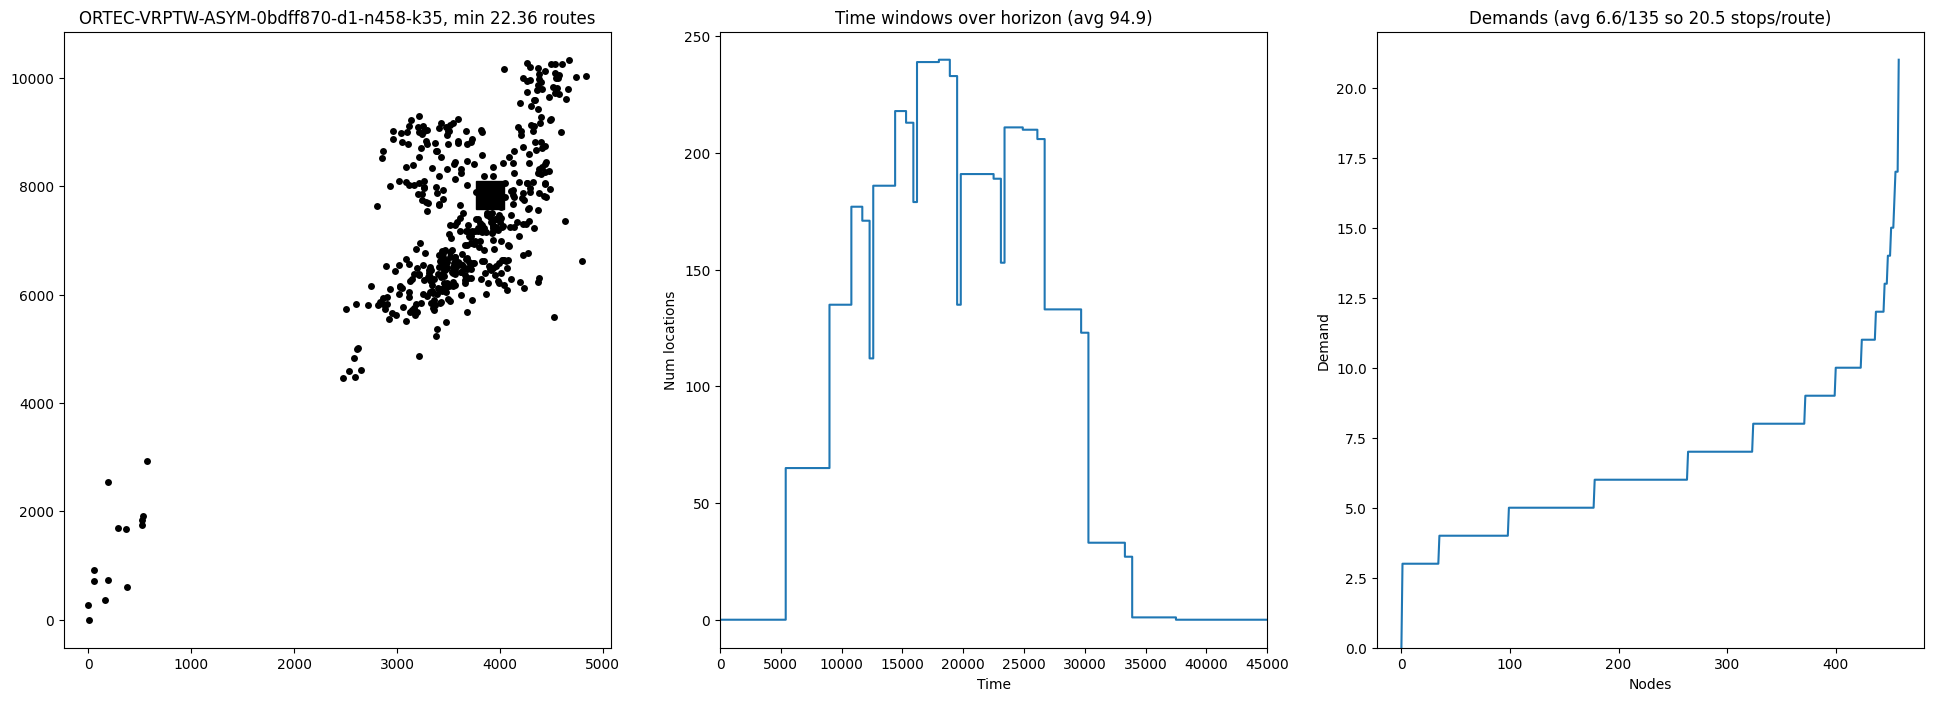

In [3]:
# Plot the instance and some properties
fig, ax = plt.subplots(1, 3, figsize=(24, 8))
plot_vrptw(ax[0], instance, title=instance_name)
plot_timew(ax[1], instance['time_window'])
plot_demands(ax[2], instance['demand'], instance['capacity'])

In [4]:
# convert it to a ProblemData object
def create_problem_data(instance):
    return ProblemData(
        instance['node_coord'],
        instance['demand'],
        instance['vehicles'],
        instance['capacity'],
        instance['time_window'],
        instance['service_time'],
        instance['distance'].astype(int),
        np.zeros_like(instance['demand'])
    )

problem_data = create_problem_data(instance)
problem_data2 = read(instance_filename)

# Configure and run Hybrid Genetic Search

In [5]:
def solve(
    data: ProblemData,
    seed: int,
    max_runtime: Optional[float] = None,
    max_iterations: Optional[int] = None,
    **kwargs,
):
    rng = XorShift128(seed=seed)
    pen_manager = PenaltyManager(data.vehicle_capacity())

    div_op = diversity.broken_pairs_distance
    pop = Population(data, pen_manager, rng, div_op)
    ls = LocalSearch(data, pen_manager, rng)

    node_ops = [
        operators.Exchange10(data, pen_manager),
        operators.Exchange20(data, pen_manager),
        operators.MoveTwoClientsReversed(data, pen_manager),
        operators.Exchange22(data, pen_manager),
        operators.Exchange21(data, pen_manager),
        operators.Exchange11(data, pen_manager),
        operators.TwoOpt(data, pen_manager),
    ]

    for op in node_ops:
        ls.add_node_operator(op)

    route_ops: list = [
        operators.RelocateStar(data, pen_manager),
        operators.SwapStar(data, pen_manager),
    ]

    for op in route_ops:
        ls.add_route_operator(op)

    crossover_op = crossover.selective_route_exchange
    algo = GeneticAlgorithm(data, pen_manager, rng, pop, ls, crossover_op)

    if max_runtime is not None:
        stop: StoppingCriterion = MaxRuntime(max_runtime)
    else:
        assert max_iterations is not None
        stop = MaxIterations(max_iterations)

    return algo.run(stop)

In [6]:
args = {
    'seed': 42,
    'max_runtime': 10
}
result = solve(problem_data, **args)
solution = result.best
print(f"Total cost of solution: {solution.cost()}")

Total cost of solution: 277925


# Plot solution

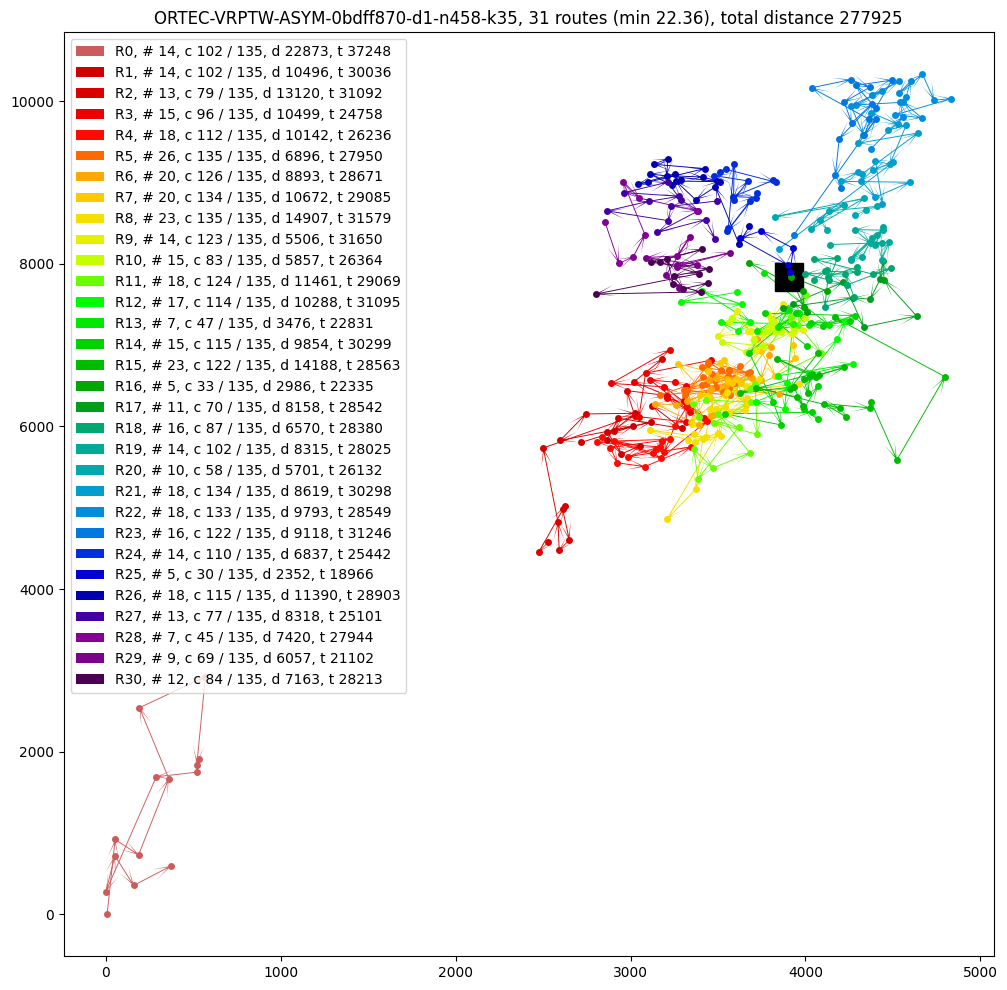

In [7]:
# Plot graphical overview of the routes
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
routes = [np.array(route) for route in solution.get_routes() if len(route) > 0]
total_dist = plot_vrptw(ax, instance, routes, title=instance_name)
assert total_dist == solution.cost()

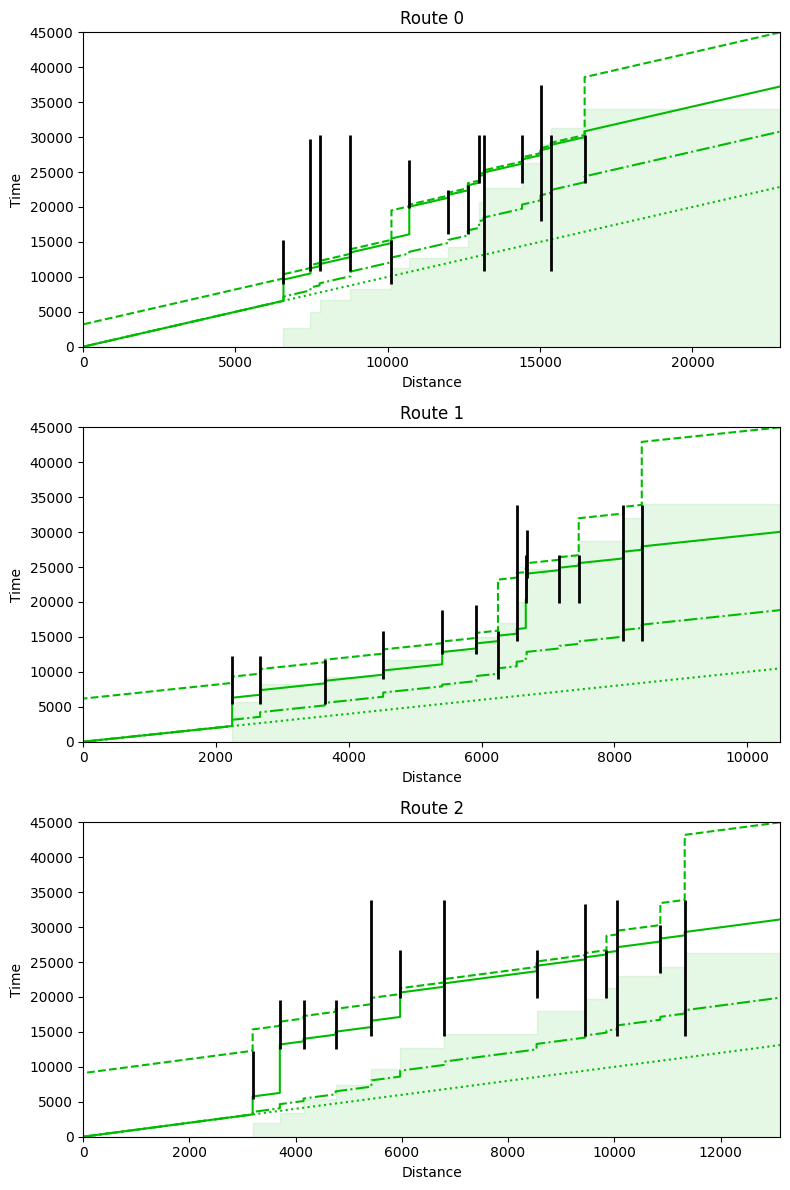

In [8]:
# Plot schedules for some individual routes
fig, axarr = plt.subplots(3, 1, figsize=(8, 12))
# Plot schedule for 3 routes to keep it clean
for i, (ax, route) in enumerate(zip(axarr, routes)):
    plot_schedule(ax, instance, [route], title=f"Route {i}")
plt.tight_layout()

# Legend:
# ----- driving + service + wait time + slack (latest feasible planning)
# _____ driving + service + wait time (earliest feasible planning)
# .-.-. driving + service time
# ..... driving time
# ||||| shaded area = fill percentage of orders up to that point (scaled 0-100%)